<a href="https://colab.research.google.com/github/Ashwin1999/COVID-19-Data-Mining/blob/Arnab/COVID_19_Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


import dataset from this link: https://github.com/Ashwin1999/COVID-19-Data-Mining

In [3]:
files = [
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/complete.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/district_level_latest.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/nation_level_daily.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/patients_data.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/state_level_daily.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/state_level_latest.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/tests_day_wise.csv',
         'https://raw.githubusercontent.com/Ashwin1999/COVID-19-Data-Mining/Arnab/COVID-DataTimeSeries(India)/tests_state_wise.csv',
]

In [44]:
testingstatewise=pd.read_csv(files[7])
testingstatewise

,Updated On,State,Total Tested,Tag (Total Tested),Positive,Negative,Unconfirmed,Cumulative People In Quarantine,Total People Currently in Quarantine,Tag (People in Quarantine),Total People Released From Quarantine,People in ICU,People on Ventilators,Num Isolation Beds,Num ICU Beds,Num Ventilators,Total PPE,Total N95 Masks,Corona Enquiry Calls,Num Calls State Helpline,Source1,Source2,Source3,Test positivity rate,Tests per thousand,Tests per million,Tests per positive case,Population NCP 2019 Projection
0,17/04/2020,Andaman and Nicobar Islands,1403.0,Samples Sent,12.0,1210,181.0,NaN,NaN,NaN,NaN,NaN,NaN,50.0,NaN,NaN,NaN,NaN,NaN,NaN,https://t.me/indiacovid/2550,NaN,NaN,0.86%,3.53,3534.0,117,397000.0
1,24/04/2020,Andaman and Nicobar Islands,2679.0,Samples Sent,27.0,NaN,246.0,NaN,614.0,Institutional,347.0,NaN,NaN,50.0,NaN,NaN,NaN,NaN,NaN,280.0,https://t.me/indiacovid/3147?single,NaN,NaN,1.01%,6.75,6748.0,99,397000.0
2,27/04/2020,Andaman and Nicobar Islands,2848.0,Samples Sent,33.0,NaN,106.0,NaN,724.0,Institutional,420.0,NaN,NaN,50.0,NaN,NaN,NaN,NaN,NaN,298.0,https://t.me/indiacovid/3365?single,NaN,NaN,1.16%,7.17,7174.0,86,397000.0
3,01/05/2020,Andaman and Nicobar Islands,3754.0,Samples Sent,33.0,NaN,199.0,NaN,643.0,Institutional,556.0,NaN,NaN,50.0,NaN,NaN,NaN,NaN,NaN,340.0,https://t.me/indiacovid/3781,NaN,NaN,0.88%,9.46,9456.0,114,397000.0
4,16/05/2020,Andaman and Nicobar Islands,6677.0,Samples Sent,33.0,NaN,136.0,NaN,16.0,Institutional,1196.0,NaN,NaN,98.0,NaN,NaN,NaN,NaN,NaN,471.0,https://t.me/indiacovid/4925,NaN,NaN,0.49%,16.82,16819.0,202,397000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3933,03/08/2020,West Bengal,956659.0,Tested,78232.0,NaN,NaN,NaN,3075.0,Government,105586.0,NaN,NaN,NaN,948.0,395.0,1969262.0,1368040.0,NaN,NaN,https://www.wbhealth.gov.in/uploaded_files/cor...,https://www.wbhealth.gov.in/pages/corona/bulletin,NaN,NaN,NaN,NaN,NaN,NaN
3934,04/08/2020,West Bengal,978980.0,Tested,80984.0,NaN,NaN,NaN,2911.0,Government,105675.0,NaN,NaN,11560.0,948.0,395.0,1979262.0,1380040.0,NaN,NaN,https://www.wbhealth.gov.in/uploaded_files/cor...,https://www.wbhealth.gov.in/pages/corona/bulletin,NaN,NaN,NaN,NaN,NaN,NaN
3935,05/08/2020,West Bengal,1003027.0,Tested,83800.0,NaN,NaN,NaN,2875.0,Government,105917.0,NaN,NaN,11560.0,948.0,395.0,1989262.0,1395040.0,NaN,NaN,https://www.wbhealth.gov.in/uploaded_files/cor...,https://www.wbhealth.gov.in/pages/corona/bulletin,NaN,NaN,NaN,NaN,NaN,NaN
3936,06/08/2020,West Bengal,1028251.0,Tested,86754.0,NaN,NaN,NaN,2918.0,Government,106083.0,NaN,NaN,11560.0,948.0,395.0,1999262.0,1409040.0,NaN,NaN,https://www.wbhealth.gov.in/uploaded_files/cor...,https://www.wbhealth.gov.in/pages/corona/bulletin,NaN,NaN,NaN,NaN,NaN,NaN


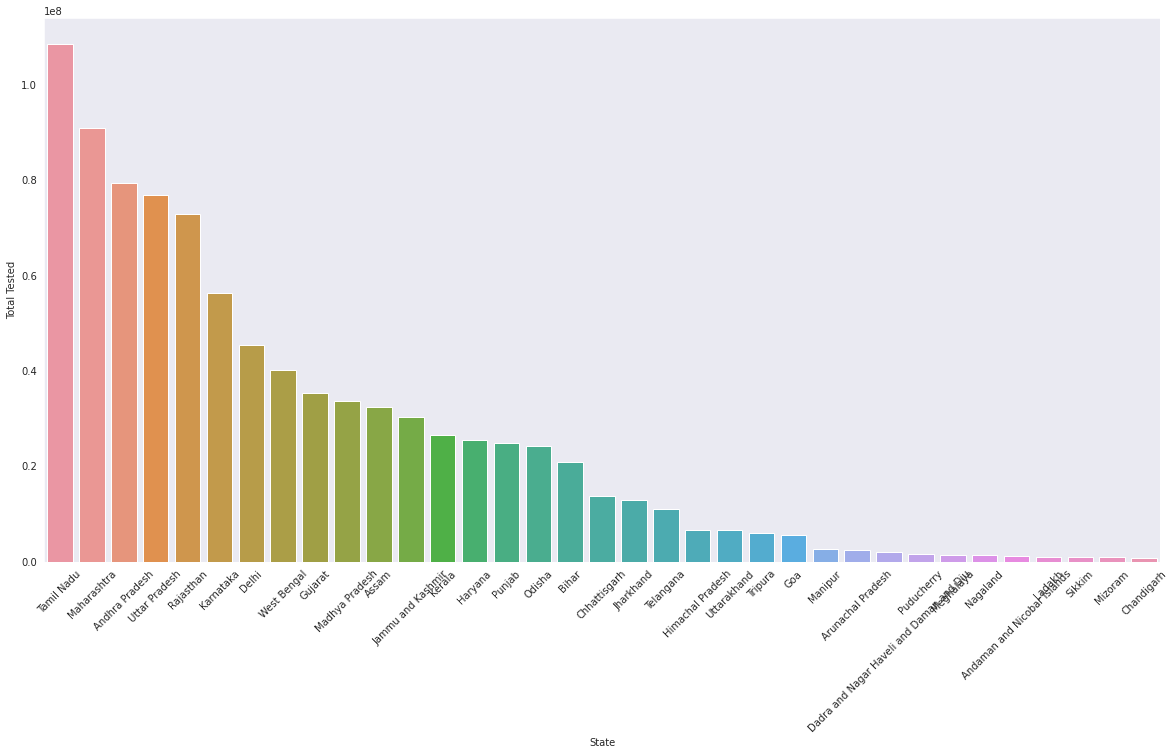

In [26]:
plt.figure(figsize=(20,10))
stateforbar=testingstatewise.groupby('State').sum().sort_values('Total Tested',ascending=False)
stateforbar.reset_index(inplace=True)
sns.barplot(x='State',y='Total Tested',data=stateforbar)
plt.xticks(rotation=45)
plt.show()

In [27]:
stateleveldaily=pd.read_csv(files[4])
stateleveldaily.head()

,Unnamed: 0,Date,State,Confirmed,Deceased,Recovered,State_Name
0,0,01-Apr-20,AN,0,0,0,Andaman and Nicobar Islands
1,1,01-Apr-20,AP,67,0,1,Andhra Pradesh
2,2,01-Apr-20,AR,0,0,0,Arunachal Pradesh
3,3,01-Apr-20,AS,15,0,0,Assam
4,4,01-Apr-20,BR,3,0,0,Bihar


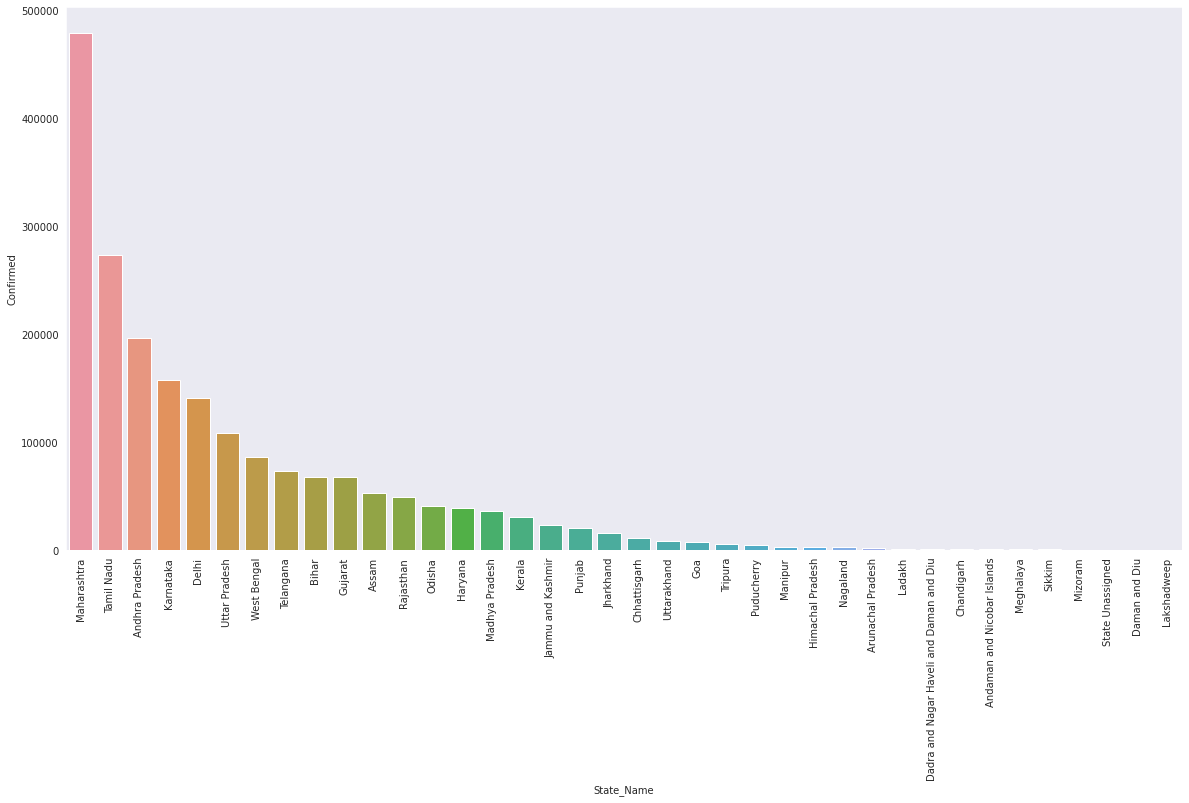

In [34]:
plt.figure(figsize=(20,10))
confirmed=stateleveldaily.groupby('State_Name').sum().sort_values('Confirmed',ascending=False)
confirmed.reset_index(inplace=True)
confirmed=confirmed[confirmed['State_Name']!='Total']
confirmed=confirmed[confirmed['State_Name']!='']
sns.barplot(x='State_Name',y='Confirmed',data=confirmed)
plt.xticks(rotation=90)
plt.show()

In [45]:
testingstatewise['Updated On']=pd.to_datetime(testingstatewise['Updated On'])
testingstatewise.dtypes

Updated On                               datetime64[ns]
State                                            object
Total Tested                                    float64
Tag (Total Tested)                               object
Positive                                        float64
Negative                                         object
Unconfirmed                                     float64
Cumulative People In Quarantine                 float64
Total People Currently in Quarantine            float64
Tag (People in Quarantine)                       object
Total People Released From Quarantine           float64
People in ICU                                   float64
People on Ventilators                           float64
Num Isolation Beds                              float64
Num ICU Beds                                    float64
Num Ventilators                                 float64
Total PPE                                       float64
Total N95 Masks                                 

In [47]:
testingstatewise['Test positivity rate'] = testingstatewise['Test positivity rate'].str.extract('(\d+)', expand=False)
testingstatewise['Test positivity rate'] = testingstatewise['Test positivity rate'].astype(float)

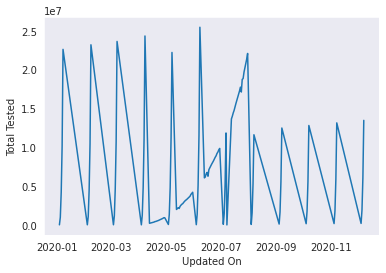

In [48]:
testingline=testingstatewise.groupby('Updated On').sum()
testingline.reset_index(inplace=True)

sns.lineplot(x='Updated On',y='Total Tested',data=testingline)

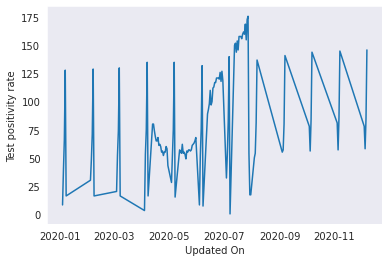

In [50]:

testingline.dtypes
sns.lineplot(x='Updated On',y='Test positivity rate',data=testingline)